# Installs, Imports, and OS/Path Setup

In [ ]:
!pip install gensim==3.8.3
!pip install keras --upgrade
!pip install tensorflow --upgrade
!pip install pandas --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.2 MB 1.4 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.5 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220527125636 requires keras<2.9,>=2.8.0rc0, but you have keras 2.9.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/si

In [ ]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, SpatialDropout1D
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Get inside the CS229 Folder

In [ ]:
%cd /content/drive/MyDrive/cs229

/content/drive/.shortcut-targets-by-id/1E5aaXKX_46t3RbThyMyJYQFjUSzGnkHI/cs229


Get stop words

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# First Part --> Configuring various settings

In [ ]:
# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

# Read in IMDb Data

Set up the pandas, use path etc. 

In [ ]:
cols = ['label', 'input']
train = pd.read_csv('imdb/imdb_data_train.csv', header=None, names=cols)
eval = pd.read_csv('imdb/imdb_data_dev.csv', header=None, names=cols)
test = pd.read_csv('imdb/imdb_data_test.csv', header=None, names=cols)

In [ ]:
train.head()

,label,input
0,positive,.....whoops - looks like it's gonna cost you a...
1,negative,"In 1970, feminists invaded the 'Miss World' be..."
2,positive,"""Johnny Dangerously"" is a sort of hit and miss..."
3,positive,"Despite its age, this film retains its undoubt..."
4,negative,"Recap: Full moon. A creature, a huge werewolf,..."


In [ ]:
train.label.value_counts()

positive    20035
negative    19965
Name: label, dtype: int64

In [ ]:
decode_map = {0: "negative", 1: "positive"}
def decode_sentiment(label):
    return decode_map[int(label)]

Text(0.5, 1.0, 'Dataset labels distribuition')

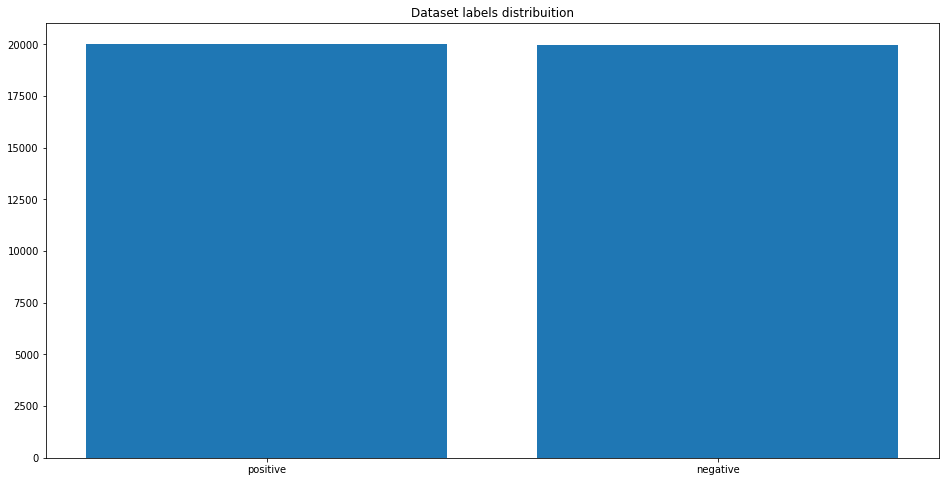

In [ ]:
label_cnt = Counter(train.label)

plt.figure(figsize=(16,8))
plt.bar(label_cnt.keys(), label_cnt.values())
plt.title("Dataset labels distribuition")

In [ ]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [ ]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
%%time
for df in [train, eval, test]:
  df.input = df.input.apply(lambda x: preprocess(x))

CPU times: user 38.4 s, sys: 69.9 ms, total: 38.5 s
Wall time: 44 s


# Configure word2vec

In [ ]:
%%time
documents = [_input.split() for _input in train.input] 

CPU times: user 651 ms, sys: 165 ms, total: 816 ms
Wall time: 818 ms


In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [ ]:
w2v_model.build_vocab(documents)

2022-06-04 08:37:19,083 : INFO : collecting all words and their counts
2022-06-04 08:37:19,088 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-06-04 08:37:19,408 : INFO : PROGRESS: at sentence #10000, processed 1248292 words, keeping 52677 word types
2022-06-04 08:37:19,742 : INFO : PROGRESS: at sentence #20000, processed 2471622 words, keeping 69494 word types
2022-06-04 08:37:20,087 : INFO : PROGRESS: at sentence #30000, processed 3715820 words, keeping 82115 word types
2022-06-04 08:37:20,445 : INFO : collected 92189 word types from a corpus of 4952574 raw words and 40000 sentences
2022-06-04 08:37:20,448 : INFO : Loading a fresh vocabulary
2022-06-04 08:37:20,548 : INFO : effective_min_count=10 retains 25238 unique words (27% of original 92189, drops 66951)
2022-06-04 08:37:20,550 : INFO : effective_min_count=10 leaves 4788663 word corpus (96% of original 4952574, drops 163911)
2022-06-04 08:37:20,642 : INFO : deleting the raw counts dictionary of 92

In [ ]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 25238


In [ ]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2022-06-04 08:37:26,080 : INFO : training model with 8 workers on 25238 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2022-06-04 08:37:27,099 : INFO : EPOCH 1 - PROGRESS: at 5.27% examples, 241700 words/s, in_qsize 15, out_qsize 0
2022-06-04 08:37:28,181 : INFO : EPOCH 1 - PROGRESS: at 12.94% examples, 279648 words/s, in_qsize 15, out_qsize 0
2022-06-04 08:37:29,207 : INFO : EPOCH 1 - PROGRESS: at 20.30% examples, 293829 words/s, in_qsize 15, out_qsize 0
2022-06-04 08:37:30,253 : INFO : EPOCH 1 - PROGRESS: at 26.75% examples, 290985 words/s, in_qsize 16, out_qsize 0
2022-06-04 08:37:31,325 : INFO : EPOCH 1 - PROGRESS: at 34.57% examples, 296533 words/s, in_qsize 15, out_qsize 0
2022-06-04 08:37:32,327 : INFO : EPOCH 1 - PROGRESS: at 41.84% examples, 300566 words/s, in_qsize 15, out_qsize 0
2022-06-04 08:37:33,331 : INFO : EPOCH 1 - PROGRESS: at 48.75% examples, 301024 words/s, in_qsize 15, out_qsize 0
2022-06-04 08:37:34,350 : INFO : EPOCH 1 - PROGRESS: 

CPU times: user 14min 30s, sys: 3.93 s, total: 14min 34s
Wall time: 7min 47s


(143371544, 158482368)

# Tokenize Text

In [ ]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train.input)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 92190
CPU times: user 4.85 s, sys: 112 ms, total: 4.96 s
Wall time: 4.99 s


In [ ]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(train.input), maxlen=SEQUENCE_LENGTH)
x_eval = pad_sequences(tokenizer.texts_to_sequences(eval.input), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test.input), maxlen=SEQUENCE_LENGTH)

CPU times: user 4.35 s, sys: 147 ms, total: 4.5 s
Wall time: 4.47 s


# Encode the Labels

In [ ]:
labels = train.label.unique().tolist()
labels

['positive', 'negative']

In [ ]:
encoder = LabelEncoder()
encoder.fit(train.label.tolist())

y_train = encoder.transform(train.label.tolist())
y_eval = encoder.transform(eval.label.tolist())
y_test = encoder.transform(test.label.tolist())

y_train = y_train.reshape(-1,1)
y_eval = y_eval.reshape(-1, 1)
y_test = y_test.reshape(-1,1)

In [ ]:
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print()
print("x_eval:", x_eval.shape)
print("y_eval:", y_eval.shape)
print()
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

x_train: (40000, 300)
y_train: (40000, 1)

x_eval: (5000, 300)
y_eval: (5000, 1)

x_test: (5000, 300)
y_test: (5000, 1)


In [ ]:
y_train[:10]

array([[1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0]])

# Now make the embedding layer

In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(92190, 300)


In [ ]:
embedding_layer = Embedding(vocab_size, 
                            W2V_SIZE, 
                            weights=[embedding_matrix], 
                            input_length=SEQUENCE_LENGTH, 
                            trainable=False)

# Build the Model

In [ ]:
lstm_out = 100

model = Sequential()
model.add(embedding_layer)
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          27657000  
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 300, 300)         0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 100)               160400    
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 27,817,501
Trainable params: 160,501
Non-trainable params: 27,657,000
_________________________________________________________________
None


In [ ]:
from keras.callbacks import ModelCheckpoint
filepath="LSTM_w2v_best_weights.{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
change_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0)

In [36]:
%%time
history = model.fit(x_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=(x_eval, y_eval), 
                    callbacks = [checkpoint, change_lr])

Epoch 1/8
40/40 [==============================] - ETA: 0s - loss: 0.5657 - accuracy: 0.6962 
Epoch 1: val_accuracy improved from -inf to 0.81560, saving model to LSTM_w2v_best_weights.01-0.8156.hdf5
40/40 [==============================] - 515s 13s/step - loss: 0.5657 - accuracy: 0.6962 - val_loss: 0.4857 - val_accuracy: 0.8156 - lr: 0.0010
Epoch 2/8
40/40 [==============================] - ETA: 0s - loss: 0.4193 - accuracy: 0.8117 
Epoch 2: val_accuracy improved from 0.81560 to 0.85260, saving model to LSTM_w2v_best_weights.02-0.8526.hdf5
40/40 [==============================] - 505s 13s/step - loss: 0.4193 - accuracy: 0.8117 - val_loss: 0.3856 - val_accuracy: 0.8526 - lr: 0.0010
Epoch 3/8
40/40 [==============================] - ETA: 0s - loss: 0.3737 - accuracy: 0.8407 
Epoch 3: val_accuracy did not improve from 0.85260
40/40 [==============================] - 499s 12s/step - loss: 0.3737 - accuracy: 0.8407 - val_loss: 0.5873 - val_accuracy: 0.7546 - lr: 0.0010
Epoch 4/8
40/40 [===

In [37]:
from keras.models import load_model
loaded_model = load_model('LSTM_w2v_best_weights.06-0.8762.hdf5')

In [38]:
%%time
score = loaded_model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

5/5 [==============================] - 28s 5s/step - loss: 0.3162 - accuracy: 0.8778

ACCURACY: 0.8777999877929688
LOSS: 0.3162410855293274
CPU times: user 25.2 s, sys: 1.53 s, total: 26.8 s
Wall time: 42.5 s


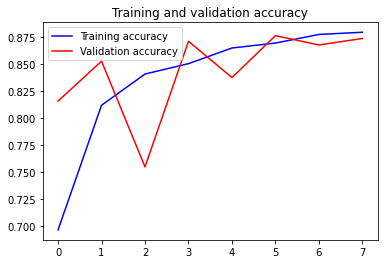

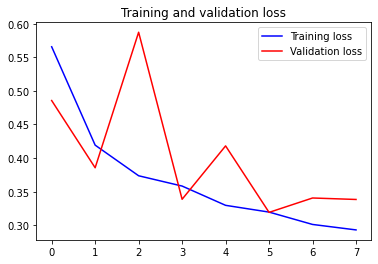

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [41]:
%%time
y_pred_1d = []
y_test_1d = list(test.label)
scores = model.predict(x_test, verbose=1, batch_size=1000)
y_pred_1d = ["negative" if score < 0.5 else "positive" for score in scores]

5/5 [==============================] - 16s 3s/step
CPU times: user 24.1 s, sys: 2.41 s, total: 26.5 s
Wall time: 20.5 s


In [42]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

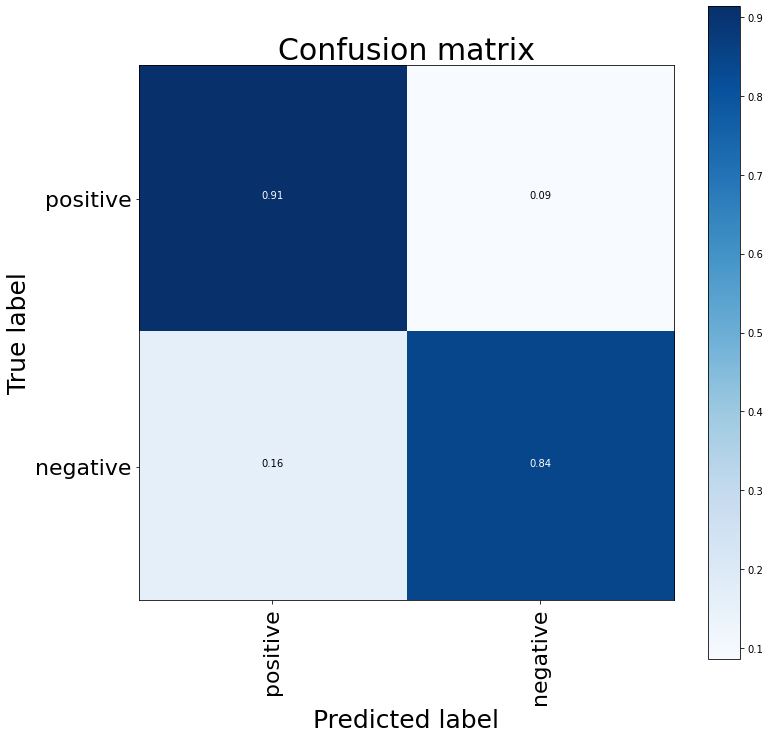

CPU times: user 444 ms, sys: 5.63 ms, total: 450 ms
Wall time: 553 ms


In [44]:
%%time
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=train.label.unique(), title="Confusion matrix")
plt.show()

In [45]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    negative       0.85      0.91      0.88      2529
    positive       0.90      0.84      0.87      2471

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



In [46]:
accuracy_score(y_test_1d, y_pred_1d)

0.8776

In [47]:
loaded_model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2022-06-04 10:16:39,337 : INFO : saving Word2Vec object under model.w2v, separately None
2022-06-04 10:16:39,340 : INFO : not storing attribute vectors_norm
2022-06-04 10:16:39,344 : INFO : not storing attribute cum_table
2022-06-04 10:16:42,062 : INFO : saved model.w2v
